In [1]:
using TrajectoryOptimization
using Altro
using RobotDynamics
using StaticArrays
using LinearAlgebra
using ForwardDiff
using FiniteDiff
using PyPlot

In [2]:
const Nx = 2 # state dimension
const Nu = 2 # control dimension
dt = 0.1 # timestep

x0 = SA[0., -4.]
xf = SA[3., 3.]
u0 = SA[1., 1.]

tf = 10.0
Nk = 21

Q = 0.5*diagm(ones(Nx))
R = 0.5*diagm(ones(Nu))


# set up dynamics
function si_dynamics(x, u, t, dt)
    return SA[x[1] + dt*u[1], x[2] + dt*u[2]]
end

struct SimpleSingleIntegrator <: RobotDynamics.DiscreteDynamics
end

function RobotDynamics.discrete_dynamics(model::SimpleSingleIntegrator, x, u, t, dt)
    return si_dynamics(x, u, t, dt)
end

# function RobotDynamics.discrete_dynamics!(model::SimpleSingleIntegrator, xn, x, u, t, dt)
#     xn .= si_dynamics(x, u, t, dt)
#     nothing
# end

function RobotDynamics.jacobian!(::RobotDynamics.StaticReturn, ::RobotDynamics.ForwardAD, model::SimpleSingleIntegrator, J, y, z)
    f(_z) = RobotDynamics.evaluate(model, RobotDynamics.getstate(z, _z), RobotDynamics.getcontrol(z, _z), RobotDynamics.getparams(z))
    J .= ForwardDiff.jacobian(f, RobotDynamics.getdata(z))
end

RobotDynamics.default_signature(::SimpleSingleIntegrator) = RobotDynamics.StaticReturn()
RobotDynamics.state_dim(::SimpleSingleIntegrator) = Nx
RobotDynamics.control_dim(::SimpleSingleIntegrator) = Nu

si_model = SimpleSingleIntegrator()

@show size(si_model)

# set up TrajOpt problem
si_obj = LQRObjective(Q, R, Nk.*Q, xf, Nk)

si_cons = ConstraintList(Nx, Nu, Nk)
add_constraint!(si_cons, GoalConstraint(xf), Nk)

@show Q

U0 = [u0 for k = 1:Nk-1]

si_prob = Problem(si_model, si_obj, x0, tf, xf=xf, constraints=si_cons)
initial_controls!(si_prob, U0)

si_solver = ALTROSolver(si_prob)

println("Initial cost = ", cost(si_solver))

solve!(si_solver)
# rollout!(si_solver)

println("Solved cost = ", cost(si_solver))

size(si_model) = (2, 2, 2)
Q = [0.5 0.0; 0.0 0.5]
Initial cost = 947.25

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 11
    Solve Time: 1967.824958 (ms)

  Covergence
    Terminal Cost: 217.1425159366376
    Terminal dJ: -9.900302873688815e-5
    Terminal gradient: 2.821115170174917e-16
    Terminal constraint violation: 1.7319479184152442e-13
    Solve Status: SOLVE_SUCCEEDED
Solved cost = 217.1425159366428


┌ Warning: A not upper triangular. Creating a new upper-triangular matrix.
└ @ Altro.Cqdldl /Users/jbwillis/.julia/packages/Altro/ePjvB/src/qdldl.jl:156


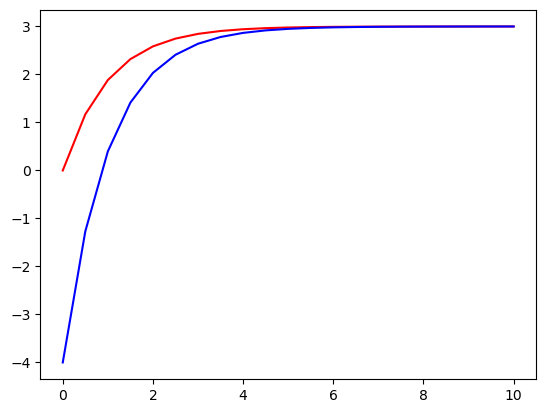

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x18035ddf0>

In [3]:
traj = get_trajectory(si_solver)

plot(traj.times, [traj.data[i][1] for i = 1:size(traj.data,1)], "r")
plot(traj.times, [traj.data[i][2] for i = 1:size(traj.data,1)], "b")

In [9]:
RobotDynamics.default_signature(si_model)

RobotDynamics.StaticReturn()